# Usando NLP para identificar se críticas/reviews de filmes são positivas ou negativas

Com esse notebook vamos demonstrar TODO o processo para a criação de um modelo que consegue avaliar se críticas/reviews de um filme são positivas ou negativas.

Sendo assim, seguiremos uma sequência lógica da abordagem que poderia ser feita por um cientista de dados, seguindo sua análise exploratória dos dados, investigações e múltiplas abordagens frente aos resultados.

O foco aqui são técnicas de NLP, e como consequência não vamos nos adentrar na escolha da técnica usada (neste caso, Regressão Linear).


## Extração dos dados

Para esse projeto, usaremos a base de dados de críticas do IMDB com tradução em português encontrada no Kaggle, no link https://www.kaggle.com/luisfredgs/imdb-ptbr

In [85]:
import pandas as pd

df = pd.read_csv("imdb-reviews-pt-br.csv")
df.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


### Se tentarmos usar os dados em um modelo agora, isso resultará em erro!

Como exemplificado a seguir, utilizar dados em texto (strings) não é compatível com modelos comuns de regressão

In [86]:
from sklearn.model_selection import train_test_split

train, test, train_classes, test_classes = train_test_split(df.text_pt, df.sentiment)

In [87]:
train.head()

26543    Ok, isso vai ser uma resenha curta e doce ... ...
6102     Para todos que leram este livro, Fanny Price a...
43712    Bem, eu dei a este filme 7. Ele era melhor que...
6674     A bipolaridade deste filme é enlouquecedora. U...
12893    Não há necessidade de repetir a sinopse aprese...
Name: text_pt, dtype: object

In [88]:
train_classes.head()

26543    neg
6102     neg
43712    pos
6674     neg
12893    pos
Name: sentiment, dtype: object

## O seguinte trecho de código retorna erro se executado!

In [89]:
from sklearn.linear_model import LogisticRegression

"""
log_reg = LogisticRegression()
log_reg.fit(train, train_classes)
acc = log_reg.score(test, test_classes)
"""

'\nlog_reg = LogisticRegression()\nlog_reg.fit(train, train_classes)\nacc = log_reg.score(test, test_classes)\n'

# Tratamento dos Dados

## Bag of Words

Uma abordagem possível para converter o texto em valores numéricos é usar um Bag of Words.

Se trata de uma abordagem simples, em que cada elemento do dataset é convertido no número de ocorrências de cada uma de suas palavras.

Com isso, o dataset pode ser representado como uma lista de strings com todas as palavras encontradas em todos os elementos, e cada elemento do dataset é uma lista numérica com o número de ocorrências de cada uma dessas palavras.

In [90]:
from sklearn.feature_extraction.text import CountVectorizer

example_text = ["Assisti um filme bom", "Assisti um filme ruim"]

example_count_vect = CountVectorizer(lowercase=False)
example_bag_of_words = example_count_vect.fit_transform(example_text)

In [91]:
example_count_vect.get_feature_names()

['Assisti', 'bom', 'filme', 'ruim', 'um']

In [92]:
example_matrix = pd.DataFrame.sparse.from_spmatrix(example_bag_of_words,
                                                   columns=example_count_vect.get_feature_names())
example_matrix.head()

,Assisti,bom,filme,ruim,um
0,1,1,1,0,1
1,1,0,1,1,1


### Agora vamos fazer isso com nossos dados e treinar um modelo!

Como nos dados reais temos muitas palavras, vamos selecionar apenas as palavras mais frequentes com o argumento *max_features*

In [93]:
count_vect = CountVectorizer(lowercase=False, max_features=50)
bag_of_words = count_vect.fit_transform(df.text_pt)

In [94]:
count_vect.get_feature_names()[:5]

['Eu', 'ao', 'apenas', 'as', 'com']

In [95]:
train, test, train_classes, test_classes = train_test_split(bag_of_words, df.sentiment)

log_reg = LogisticRegression()
log_reg.fit(train, train_classes)
acc = log_reg.score(test, test_classes)

print(acc)

0.6561261625556005


In [96]:
def sentiment_classification(df: pd.DataFrame, text_column: str, max_features: int=50):
    """Converts the DataFrame's text column into a bag of words and classifies each text by sentiment
    with a Logistic Regression
    """
    count_vect = CountVectorizer(max_features=max_features)
    bag_of_words = count_vect.fit_transform(df[text_column])
    
    train, test, train_classes, test_classes = train_test_split(bag_of_words, df.sentiment)
    log_reg = LogisticRegression()
    log_reg.fit(train, train_classes)
    acc = log_reg.score(test, test_classes)

    print(acc)
    return log_reg


# Melhorando o modelo

Para um modelo trivial, até que não foi tão ruim! Conseguimos prever 65% dos casos, mas a seguir vamos estudar como melhorar nosso modelo para ser mais preciso em previsões.

Para isso, vamos gerar uma WordCloud para visualizar quais classes podem ser mais relevantes para nosso modelo.

In [97]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(texts: list, figsize: tuple=(15, 12)):
    """Extracts and plots a WordCloud of a list of texts """
    
    all_text = ' '.join([text for text in texts])
    word_cloud = WordCloud(width=900, height=500, max_font_size=110, collocations=False).generate(all_text)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(word_cloud, interpolation='bilinear')
    
    return word_cloud

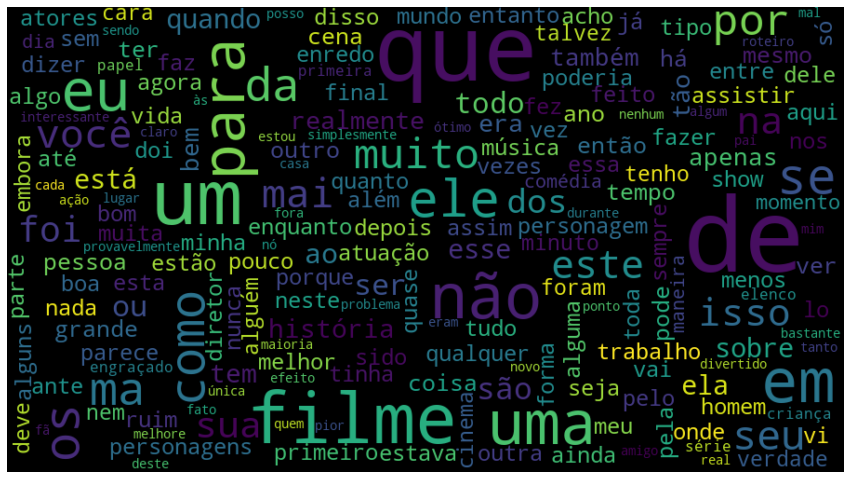

In [98]:
plot_word_cloud(df.text_pt)

## Vamos separar as palavras de acordo com o sentimento e ver se notamos alguma diferença

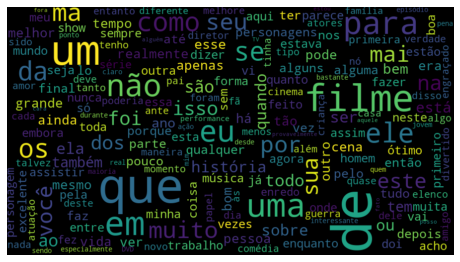

In [99]:
positives = df[df.sentiment == "pos"]

plot_word_cloud(positives.text_pt, (8, 5))

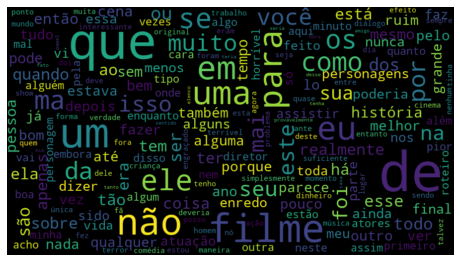

In [100]:
negatives = df[df.sentiment == "neg"]

plot_word_cloud(negatives.text_pt, (8, 5))

# Análise das palavras

Vamos fazer uma análise das palavras mais frequentes, para decidir com embasamento quais são aceitáveis de serem retiradas do dataset

---

### NLTK

NLTK é uma das bibliotecas de processamento de linguagem natural mais completas atualmente, e é amplamente utilizada tanto em pesquisas como no mercado de trabalho.

Vamos utilizá-la superficialmente neste Notebook, mas vale a pena se familiarizar mais profundamente com a biblioteca caso se interesse na área de NLP!

---

## Tokenização

Vamos converter nossa base de críticas em uma base de **Tokens**, isto é, uma lista de palavras, a fim de facilitar a visualização e tratamento da nossa base.

No nosso caso, utilizaremos o RegexpTokenizer para selecionar como Tokens apenas os caractéres alfabéticos do nosso texto, ignorando a pontuação.

In [101]:
import nltk
from nltk import tokenize
import seaborn as sns

#nltk.download("all")

In [102]:
all_text = ' '.join([text for text in df.text_pt])

tokenizer = tokenize.RegexpTokenizer(r'\w+') # pegamos apenas as letras, ignorando pontuação e números
tokens = tokenizer.tokenize(all_text)
freqs = nltk.FreqDist(tokens)
print(freqs)

<FreqDist with 157001 samples and 10930902 outcomes>


In [103]:
df_freq = pd.DataFrame({"word": list(freqs.keys()), "frequency": list(freqs.values())})
df_freq.head()

,word,frequency
0,Mais,1594
1,uma,131190
2,vez,15403
3,o,247255
4,Sr,1783


Com isso podemos verificar, por exemplo, quais são as 15 palavras mais comuns do nosso dataset.

In [104]:
df_freq.nlargest(columns="frequency", n=15)

,word,frequency
20,de,418565
14,que,330177
42,e,307693
3,o,247255
7,um,217830
99,a,211472
45,é,197337
8,filme,152842
191,em,133351
29,não,131507


### Vamos apresentar essa informação na forma de um Pareto Plot

O Pareto Plot resume as informações da tabela, evidênciando mais claramente discrepâncias entre a frequência de palavras, além de representar a porcentagem que tais palavras ocupam cumulativamente na base de dados inteira.

In [105]:
def get_frequency_dataframe(frequency_distribution: dict, ammount=None) -> pd.DataFrame:
    """From a frequency distribution dictionary, returns a frequency DataFrame
    
    Optionally, can receive an ammount value, only taking in consideration the N more frequent values.
    This can speed up computation of the values in the resulting DataFrame greatly.
    """
    df_freq = pd.DataFrame({
        "word": list(frequency_distribution.keys()),
        "frequency": list(frequency_distribution.values())
    })
    if ammount:
        df_freq = df_freq.nlargest(columns="frequency", n=ammount)
    total_freq = df_freq.frequency.sum()
    df_freq["percentage"] = df_freq.frequency.cumsum() / total_freq * 100
    
    return df_freq

In [106]:
def plot_word_frequency(texts: list, ammount: int=10):
    """Calculates and presents a Pareto Plot of the frequency of each word in the DataFrame """
    all_text = ' '.join([text for text in texts])
    
    tokenizer = tokenize.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(all_text)
    freqs = nltk.FreqDist(tokens)
    df_freq = get_frequency_dataframe(freqs, ammount)
    
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(data=df_freq, x="word", y="frequency", palette='GnBu')
    ax2 = ax.twinx()
    ax2.set(ylabel="Porcentagem")
    sns.lineplot(data=df_freq, x="word", y="percentage", color='red', ax=ax2)
    ax.set(ylabel="Frequência", xlabel="")
    plt.show()
    
    return df_freq

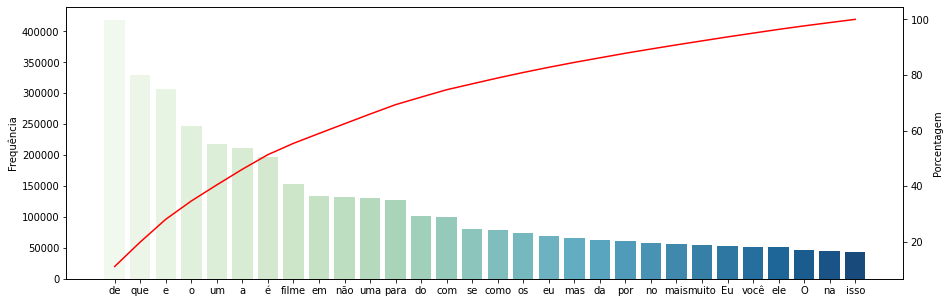

In [107]:
df_freq = plot_word_frequency(df.text_pt, 30)

# Tratando os dados

Para obter melhores resultados, vamos usar múltiplas técnicas para induzir palavras mais semânticamente relevantes a terem maior frequência e peso nos modelos que treinaremos.

---

## Stopwords

Stopwords são conectivos que, no caso do nosso modelo, são irrelevantes para identificar os sentimentos de um texto.

Vamos remover todas as Stopwords da nossa base e verificar como ficam os dados.

No caso abaixo também removemos a acentuação com a biblioteca unidecode, a fim de evitar variações criadas por erros ortográficos.

In [108]:
import unidecode

stopwords = [unidecode.unidecode(word) for word in nltk.corpus.stopwords.words("portuguese")]
print(stopwords[:10])

['de', 'a', 'o', 'que', 'e', 'e', 'do', 'da', 'em', 'um']


In [109]:
all_filtered_reviews = []
for review in df.text_pt:
    filtered_review = []
    tokenizer = tokenize.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(review)
    for tok in tokens:
        word = unidecode.unidecode(tok.lower()) # minimizamos e removemos os acentos do texto
        if word not in stopwords:
            filtered_review.append(word)
    all_filtered_reviews.append(' '.join(filtered_review))

df["text_treated"] = all_filtered_reviews

In [110]:
print(all_filtered_reviews[2]) # Exemplo de review tratada

primeiro tudo odeio raps imbecis poderiam agir arma pressionada contra testas tudo fazem amaldicoar atirar outro agir versao cliche gangsters filme leva cinco minutos explicar acontecendo antes armazem unico personagem simpatico nesse filme excecao teto unico metade cerebro william paxton william sadler ambos hill billies sadler tao vilao quanto gangsteres gostava desde comeco filme cheio violencia sentido especialidade walter hills pessoas caindo janelas vidros voando toda parte praticamente nenhum enredo grande problema torce ninguem todo mundo morre exceto paxton teto todos recebem merecem dois unicos negros podem atuar teto viciado atores profissao irritantes rappers feios fique longe dessa porcaria observe 48 horas 1 2 vez disso minimo personagens gosta senso humor nada alem atores reais elenco


### Apenas de remover as stopwords e acentuações nosso modelo já apresentou resultados um pouco melhores!

De 65,98%, chegamos a 68,86% de acerto

In [111]:
sentiment_classification(df, "text_treated")

0.692600080873433


LogisticRegression()

Agora podemos ver palavras mais interessantes!

Com o auxílio de WordClouds, podemos ver que existem palavras mais frequentes, como "filme", que são dominantes em ambas as críticas positivas e negativas, indicando que elas não têm relevância semântica para nós, o que trataremos no futuro.

Também notamos algumas palavras que são, de certa forma, redundantes, como "filme" e "filmes", as quais vamos querer reduzir a um radical comum para facilitar futuros tratamentos.

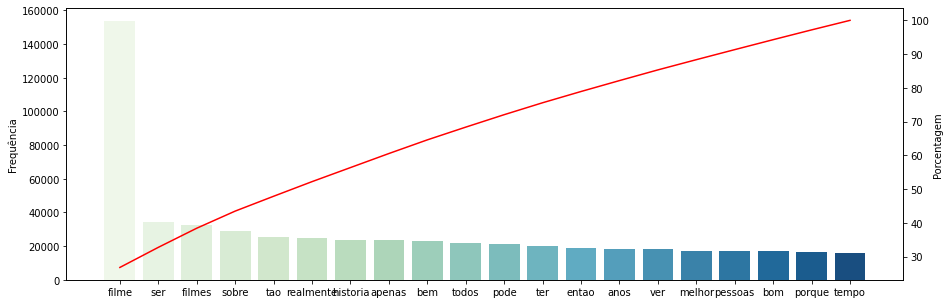

In [112]:
df_freq = plot_word_frequency(df.text_treated, 20)

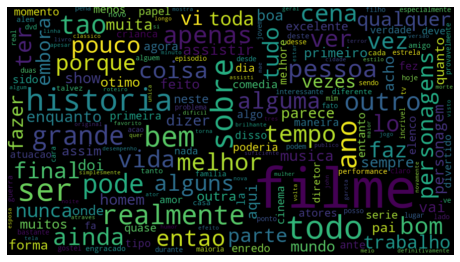

In [113]:
positives = df[df.sentiment == "pos"]

plot_word_cloud(positives.text_treated, (8, 5))

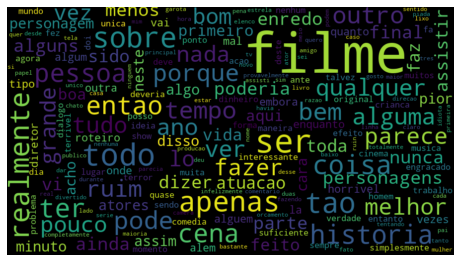

In [114]:
negatives = df[df.sentiment == "neg"]

plot_word_cloud(negatives.text_treated, (8, 5))

## Stemmers

Vamos começar reduzindo as palavras encontradas a um radical comum, como comentamos acima. Para isso, vamos utilizar a ferramenta Stemmer.

Segue um exemplo simples do funcionamento do Stemmer.

In [115]:
from nltk import RSLPStemmer

stemmer = RSLPStemmer()
print(stemmer.stem("corredor"))
print(stemmer.stem("correria"))
print(stemmer.stem("correndo"))
print(stemmer.stem("corroendo"))

corr
corr
corr
corro


In [116]:
all_filtered_reviews = []
for review in df.text_pt:
    filtered_review = []
    tokenizer = tokenize.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(review)
    for tok in tokens:
        word = unidecode.unidecode(tok.lower())
        if word not in stopwords:
            filtered_review.append(stemmer.stem(word))
    all_filtered_reviews.append(' '.join(filtered_review))

df["text_treated"] = all_filtered_reviews

### Usando Stemmers a nossa precisão melhorou mais ainda, e os resultados dão novas indicativas de para onde seguir também!

De uma precisão inicial de 65,98%, chegamos a 69,41% de acerto!

Além disso, podemos verificar nas WordClouds que agora palavras incomuns entre sentimentos negativo e positivo começam a ter maior predominância. Por exemplo, "**gost**", provavelmente relacionado a "**gostar**", está crescendo no WordCloud de críticas positivas, enquanto em críticas negativas "**ruim**" vem se destacando mais.

In [117]:
sentiment_classification(df, "text_treated")

0.6895268904164982


LogisticRegression()

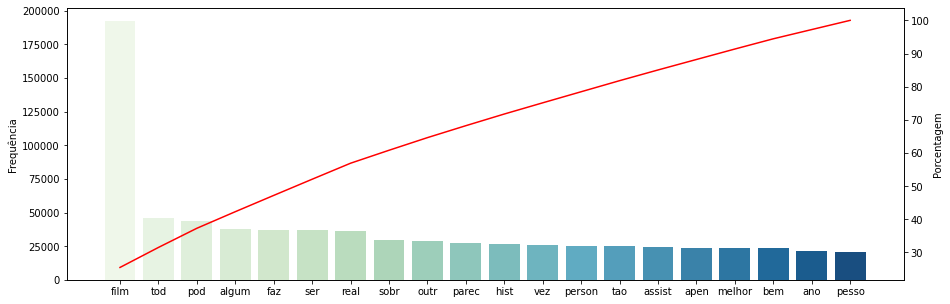

In [118]:
df_freq = plot_word_frequency(df.text_treated, 20)

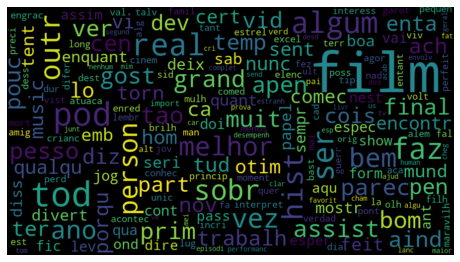

In [119]:
positives = df[df.sentiment == "pos"]

plot_word_cloud(positives.text_treated, (8, 5))

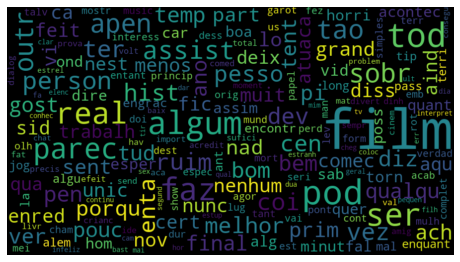

In [120]:
negatives = df[df.sentiment == "neg"]

plot_word_cloud(negatives.text_treated, (8, 5))

Dado isso, podemos resumir o nosso tratamento de dados à seguinte função:

In [138]:
def get_filtered_reviews(reviews: list) -> list:
    all_filtered_reviews = []
    
    for review in reviews:
        filtered_review = []
        tokenizer = tokenize.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(review)
        for tok in tokens:
            word = unidecode.unidecode(tok.lower())
            if word not in stopwords:
                filtered_review.append(stemmer.stem(word))
        all_filtered_reviews.append(' '.join(filtered_review))
    
    return all_filtered_reviews

# Feature Extraction

## TF-IDF

O TF-IDF cria pesos para cada uma das palavras de cada um dos exemplos, levando em consideração o dataset completo de frases, a fim de dar maior destaque às palavras que melhor distinguem as frases.

Podemos pensar no TF-IDF como um Bag of Words, mas ao invés de uma frase apresentar apenas os valores binários para cada palavra (indicando se a palavra do dataset está presente ou não na frase), as palavras têm valores flutuantes entre 0 e 1, indicando sua "importância" na frase.

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

frases = ["Esse filme foi incrível", "Esse filme foi horrível"]

tfidf = TfidfVectorizer(max_features=50)
feats = tfidf.fit_transform(frases)
pd.DataFrame(
    feats.todense(),
    columns=tfidf.get_feature_names()
)

,esse,filme,foi,horrível,incrível
0,0.448321,0.448321,0.448321,0.000000,0.630099
1,0.448321,0.448321,0.448321,0.630099,0.000000


### Vamos atualizar o nosso método de classificação para utilizar o TF-IDF no lugar do Bag of Words

In [134]:
def sentiment_classification(df: pd.DataFrame, text_column: str, max_features: int=50):
    """Converts the DataFrame's text column into a bag of words and classifies each text by sentiment
    with a Logistic Regression
    """
    tfidf = TfidfVectorizer(max_features=max_features)
    feats = tfidf.fit_transform(df[text_column])
    
    train, test, train_classes, test_classes = train_test_split(feats, df.sentiment, random_state=1)
    log_reg = LogisticRegression()
    log_reg.fit(train, train_classes)
    acc = log_reg.score(test, test_classes)

    print(acc)
    return log_reg

In [123]:
sentiment_classification(df, "text_pt")

0.6645369995956328


LogisticRegression()

In [124]:
sentiment_classification(df, "text_treated")

0.6962393853619087


LogisticRegression()

Essa mudança simples já trouxe resultados um pouco melhores!

---

## NGrams

NGrams permitem que consideremos a relação ENTRE palavras no nosso modelo, ao criar elementos que unem as palavras de N em N, como demonstrado no exemplo a seguir.

In [125]:
from nltk import ngrams

frase = ["esse", "filme", "foi", "incrivel"]
pairs = ngrams(frase, 2)
print(list(pairs))
pairs = ngrams(frase, 3)
print(list(pairs))

[('esse', 'filme'), ('filme', 'foi'), ('foi', 'incrivel')]
[('esse', 'filme', 'foi'), ('filme', 'foi', 'incrivel')]


### Precisamos de um número de *features* máximo maior!

Como vai ser exemplificado a seguir, precisamos de mais features para que a adição de Ngrams possa ser percebida, pois combinações par a par são infrequentes demais para serem selecionadas como uma das 50 *features* mais relevantes. Sendo assim, não limitamos o valor de **max_features** do nosso modelo.

Dada essa mudança, para evidenciar a melhora dos resultados, podemos comparar o resultado com mais *features* **com** e **sem** os Ngrams!


Primeiro, **sem os Ngrams**:

In [149]:
def sentiment_classification(df: pd.DataFrame, text_column: str):
    """Converts the DataFrame's text column into a bag of words and classifies each text by sentiment
    with a Logistic Regression
    """
    tfidf = TfidfVectorizer()
    feats = tfidf.fit_transform(df[text_column])
    
    train, test, train_classes, test_classes = train_test_split(feats, df.sentiment, random_state=10)
    log_reg = LogisticRegression()
    log_reg.fit(train, train_classes)
    acc = log_reg.score(test, test_classes)

    print(acc)
    return log_reg

In [150]:
sentiment_classification(df, "text_treated")

0.886696320258795


LogisticRegression()

In [151]:
def sentiment_classification(df: pd.DataFrame, text_column: str):
    """Converts the DataFrame's text column into a bag of words and classifies each text by sentiment
    with a Logistic Regression
    """
    tfidf = TfidfVectorizer(ngram_range=(1, 2))
    feats = tfidf.fit_transform(df[text_column])
    
    train, test, train_classes, test_classes = train_test_split(feats, df.sentiment, random_state=10)
    log_reg = LogisticRegression()
    log_reg.fit(train, train_classes)
    acc = log_reg.score(test, test_classes)

    print(acc)
    return log_reg

E agora, **com Ngrams**:

In [152]:
sentiment_classification(df, "text_treated")

0.887747674888799


LogisticRegression()

Também vamos analisar as palavras que a regressão logística determinou como indicadores mais relevantes do sentimento de uma crítica.

Também percebemos que **não aparece nenhum Ngram entre as 50 features mais relevantes**, e por isso que o número máximo de features deve ser aumentado para que o uso de Ngrams resulte em alguma diferença significativa.

In [153]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
feats = tfidf.fit_transform(df["text_treated"])
    
train, test, train_classes, test_classes = train_test_split(feats, df.sentiment, random_state=10)
log_reg = LogisticRegression()
log_reg.fit(train, train_classes)

weights = pd.DataFrame(
    log_reg.coef_[0].T,
    index = tfidf.get_feature_names()
)

weights.nlargest(10, 0)

,0
otim,9.959804
excel,9.202354
maravilh,6.740133
perfeit,6.685148
incri,5.868331
favorit,5.820568
divert,5.374410
brilh,4.447485
ador,4.433212
am,4.249455


Podemos perceber que muitos dos elementos com maiores pesos no TF-IDF são evidentemente indicadores de sentimento, como "**bem**", "**gost**" (de gostar), "**melhor**" e etc..

---

Com esses tratamentos e análises, conseguimos obter um modelo razoável para a predição de sentimentos nos nossos dados. Com poucas modificações a acurácia do modelo pode ser melhorada em muito, mas devemos tomar cuidado para não causar **overfitting**, que é assunto para outro momento.

Embora a análise e o caminho para chegar até aqui tenha sido longo, no final podemos resumir o processo para obter nosso modelo de previsão de sentimento no pequeno parágrafo de código a seguir:

In [154]:
df["text_treated"] = get_filtered_reviews(df.text_pt)
model = sentiment_classification(df, "text_treated")

0.887747674888799
